In [95]:
#importing packages
#for data loading
import os
from kaggle.api.kaggle_api_extended import KaggleApi
#for data manipulation
import pandas as pd
import numpy as np
#for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import pointbiserialr

# Prompt the user for their Kaggle credentials
kaggle_username = input("Enter your Kaggle username: ")
kaggle_api_key = input("Enter your Kaggle API key: ")

# Set up the Kaggle API
api = KaggleApi()

# Set the Kaggle environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_api_key

# Authenticate with the Kaggle API
api.authenticate()

# Define the dataset and where to save it
dataset_name = 'pavansubhasht/ibm-hr-analytics-attrition-dataset'
save_path = './data/'

# Check if the dataset is already downloaded
if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists(os.path.join(save_path, 'attrition.csv')):
  # Download the dataset
    api.dataset_download_files(dataset_name, path=save_path, unzip=True)
else:
    print("Dataset already exists.")

# Now you can use the dataset from the specified location

In [75]:
#reading data
df = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [76]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## Data description
I have overall 1470 employee records and 35 columns with employee data. There seem to be no missing values but I still have to check for duplicates. The data includes information about:
- the employee's demographics such as age, home address, gender or marital status
- information about the current position (department, job level or role)
- satisfaction scores (with leader, job or team)
- information about the relationship between the employee and company (tenure, promotions, salary, overtime)
- binary field if the employee left or not (attrition)

# Exploratory Data Analysis
## Data Preprocessing
In this section, I will:
- examing the dataset for missing values and outliers
- handle missing values (if any)
- encode categorical variables
- check for imbalances in the target variable (attrition)

### Step 1: Missing values, duplicates and outliers

In [78]:
# Step 1: Checking for Missing Values
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values
# Step 2: Checking for Duplicates
# Check for duplicate rows in the dataset
duplicates = df[df.duplicated()]
# Display duplicate rows (if any)
if not duplicates.empty:
    print("\nDuplicate Rows:")
    print(duplicates)
else:
    print("\nNo duplicate rows found.")
#check for outliers
# Select only the numeric columns
numeric_columns = df.select_dtypes(include=[np.number])

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define a threshold to identify potential outliers
threshold = 1.5

# Identify potential outliers
potential_outliers = ((numeric_columns < (Q1 - threshold * IQR)) | (numeric_columns > (Q3 + threshold * IQR)))

# Count the number of potential outliers in each numeric column
outlier_counts = potential_outliers.sum()

# Display columns with potential outliers and their counts
print("Columns with potential outliers:")
print(outlier_counts[outlier_counts > 0])


No duplicate rows found.
Columns with potential outliers:
MonthlyIncome              114
NumCompaniesWorked          52
PerformanceRating          226
StockOptionLevel            85
TotalWorkingYears           63
TrainingTimesLastYear      238
YearsAtCompany             104
YearsInCurrentRole          21
YearsSinceLastPromotion    107
YearsWithCurrManager        14
dtype: int64


In [79]:
outliercols = outlier_counts[outlier_counts > 0]
outlier_column_names = list(outliercols.index)

# Now, 'outlier_column_names' is a list of the column names
print(outlier_column_names)

['MonthlyIncome', 'NumCompaniesWorked', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


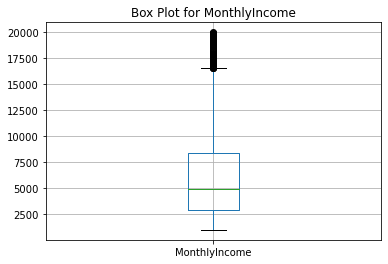

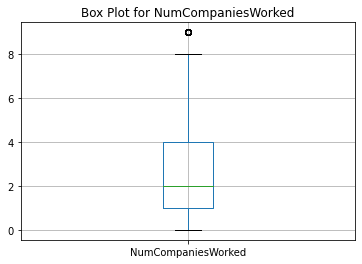

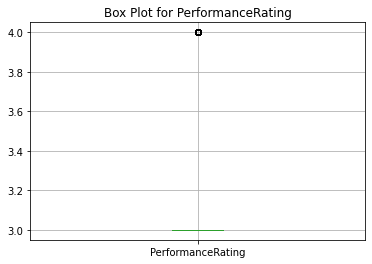

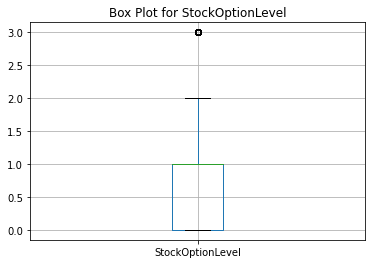

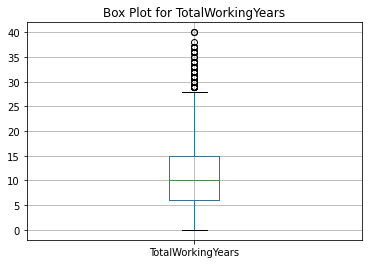

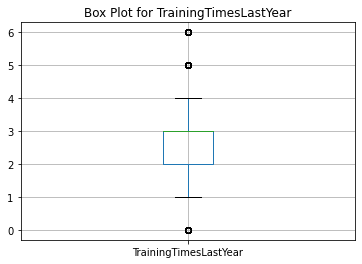

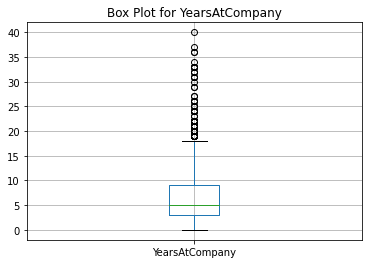

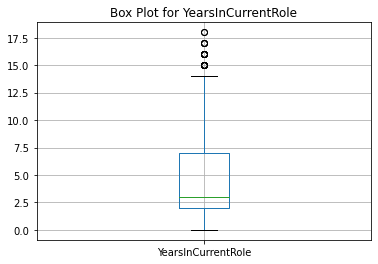

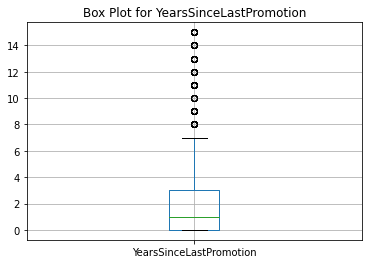

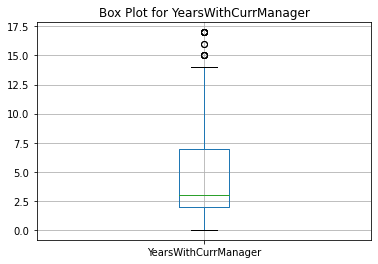

In [80]:
for column in outlier_column_names:
    df.boxplot(column=column)
    plt.title(f'Box Plot for {column}')
    plt.show()

### Interpretation
I have no missing values, no duplicates but I do have some columns where I have outliers. However, the outliers don't seem to be data quality issues but it makes sense that there are outliers regarding salary, years in the current role or total working years. I will leave the outliers in for now and decide later what to do with them depending on how sensitive my model would be for outliers.

## Visual data inspection
Next, besides to look at the outliers, I want to get a better feeling about my data, and the distribution of it. For this, I am looking at histograms for the numerical and non-numerical columns.

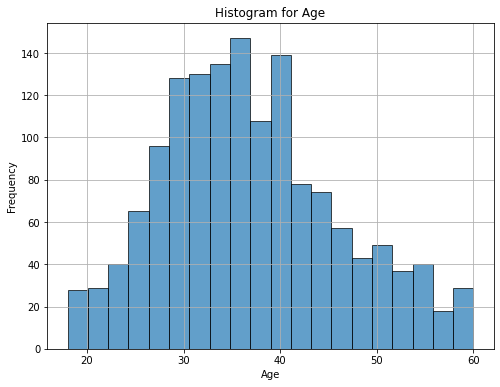

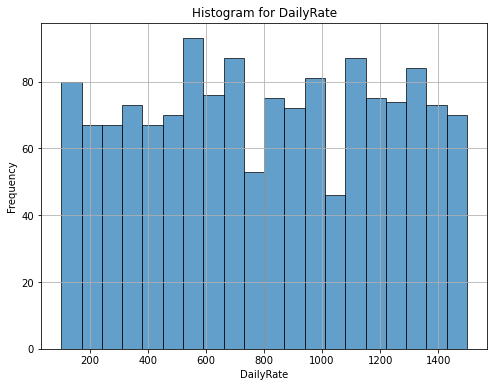

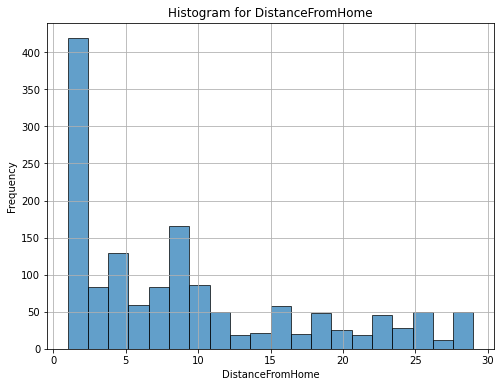

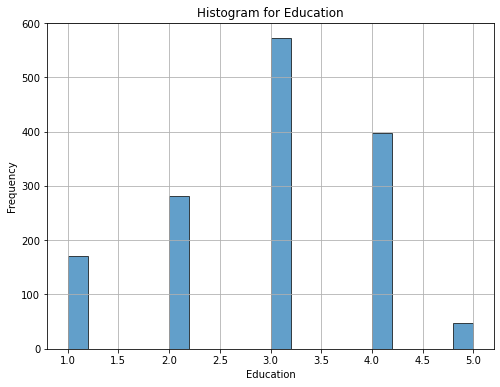

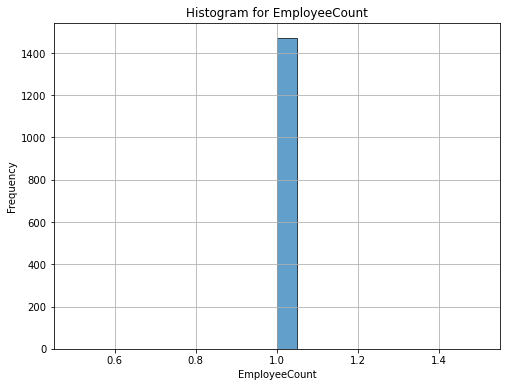

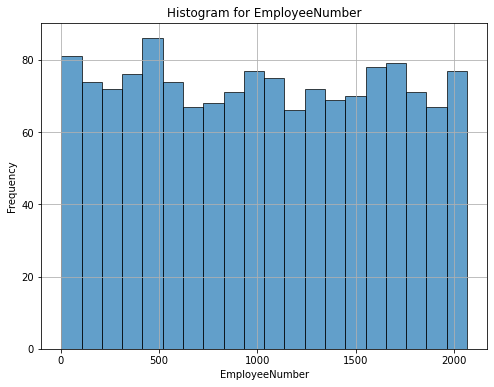

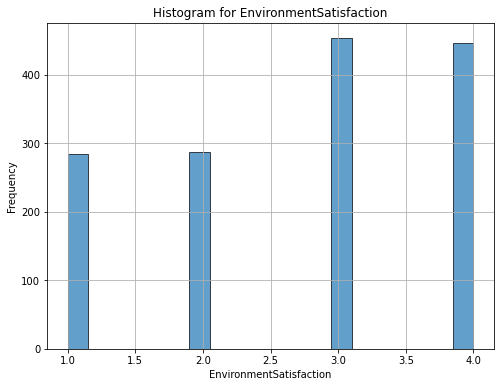

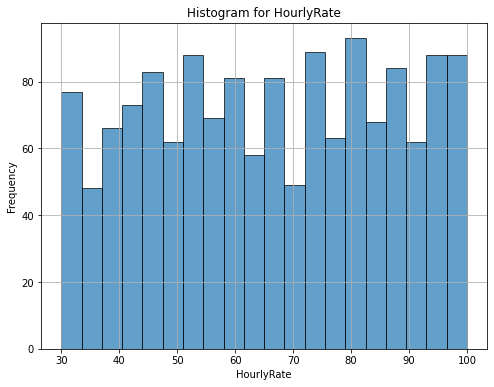

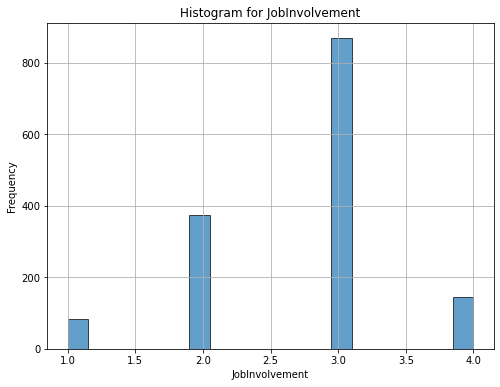

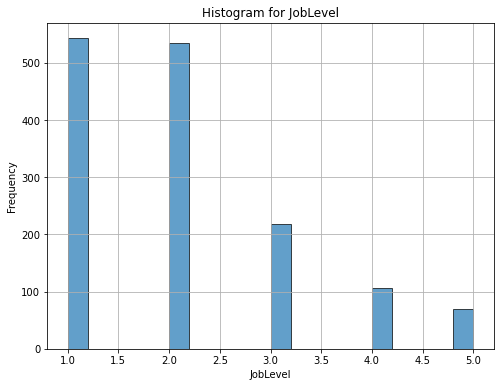

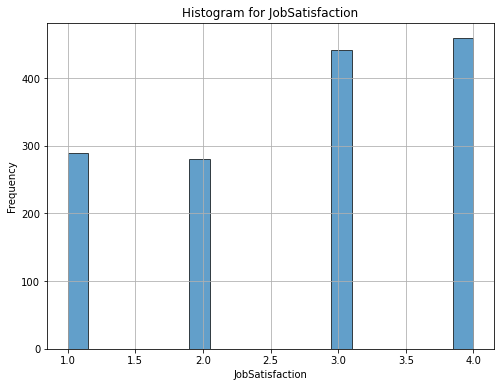

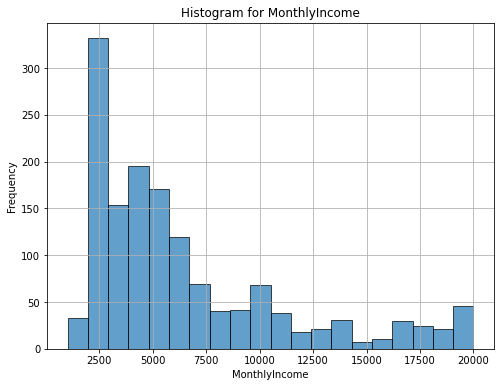

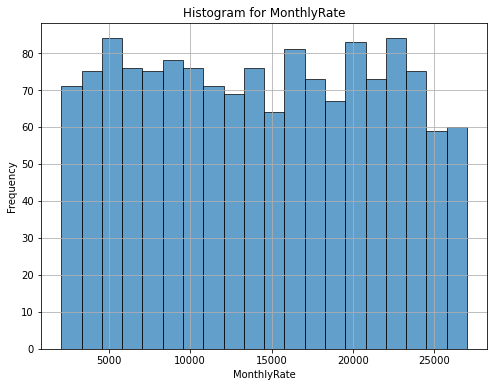

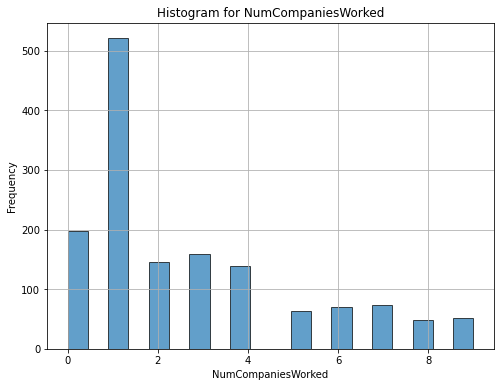

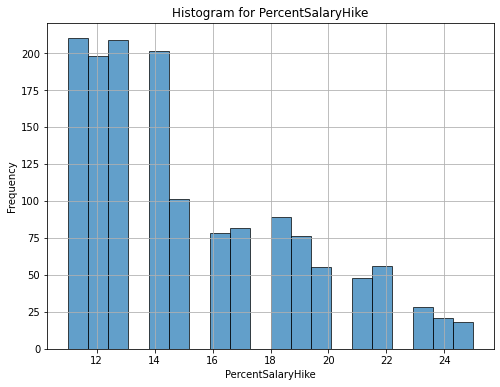

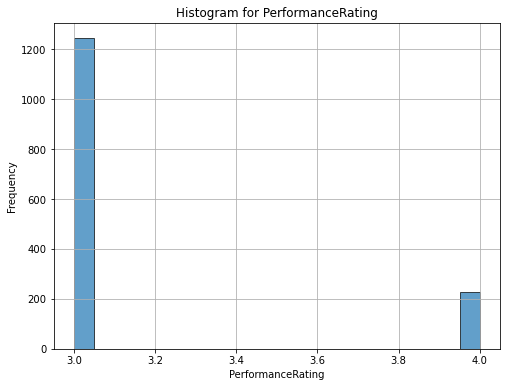

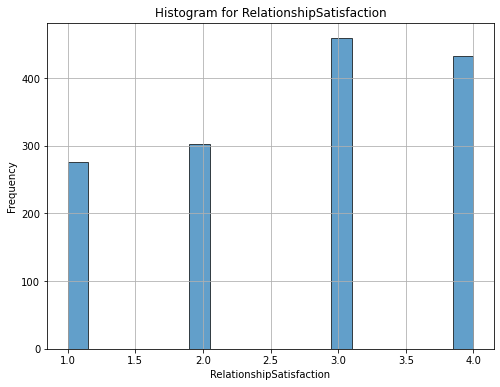

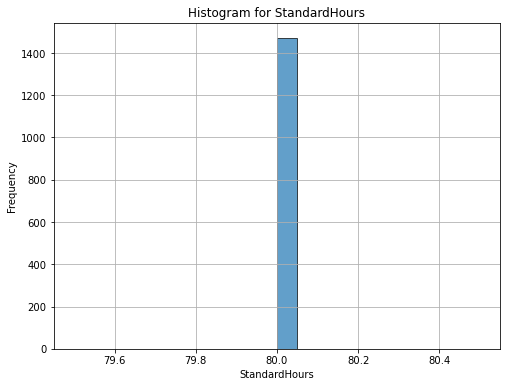

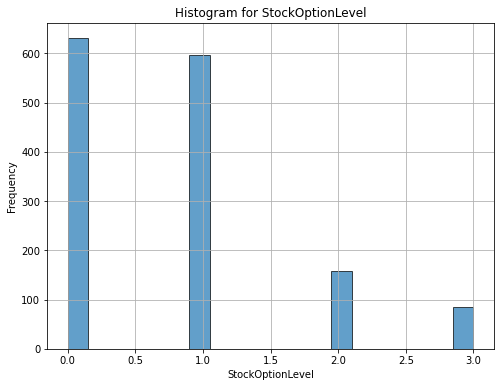

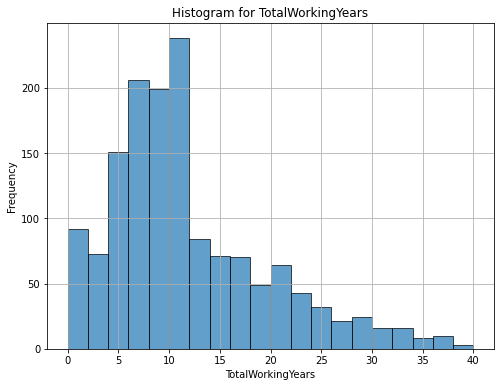

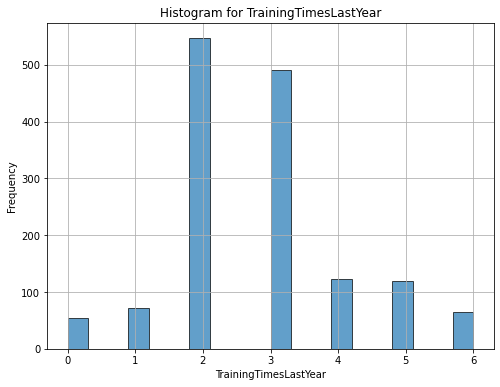

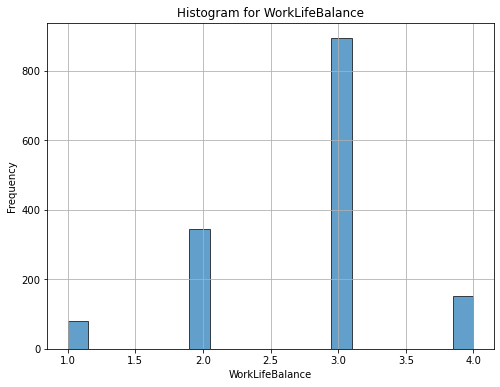

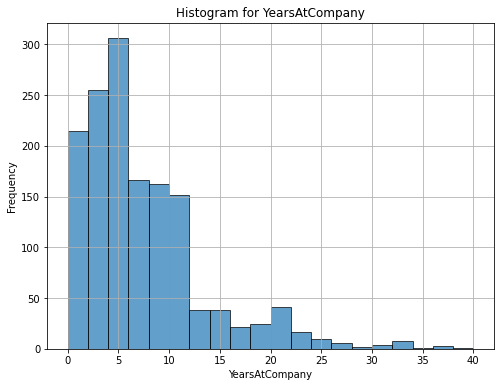

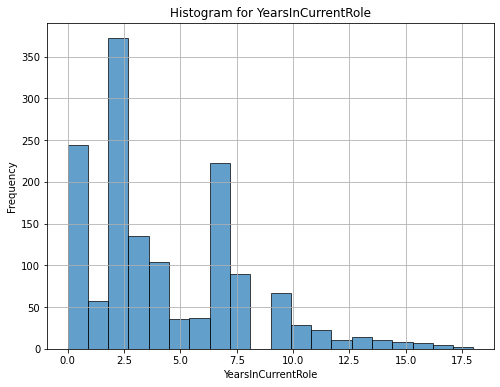

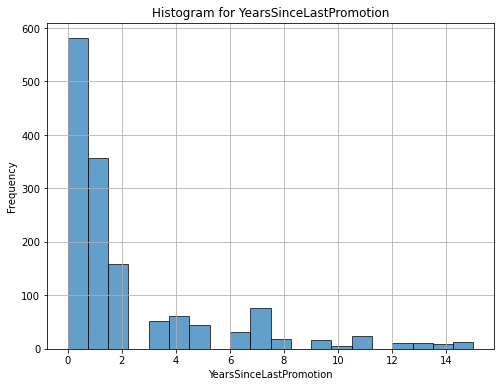

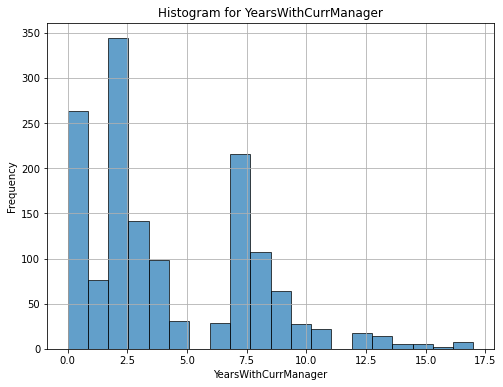

In [81]:
#visualise by using a histogram for each column
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

The data in the numeric columns looks pretty good. I can drop the following columns because they don't give me any value:
- Employee Count (only 1s)
- Employee Number (don't need the unique identifier anymore)
- StandardHours (everyone seems to have the same hours)

In [82]:
#dropping 3 columns
df = df.drop(["StandardHours","EmployeeCount","EmployeeNumber"], axis=1)

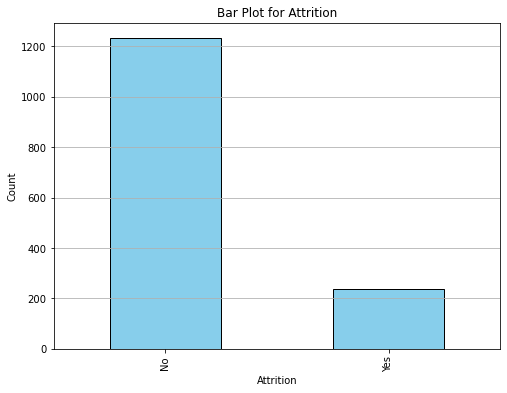

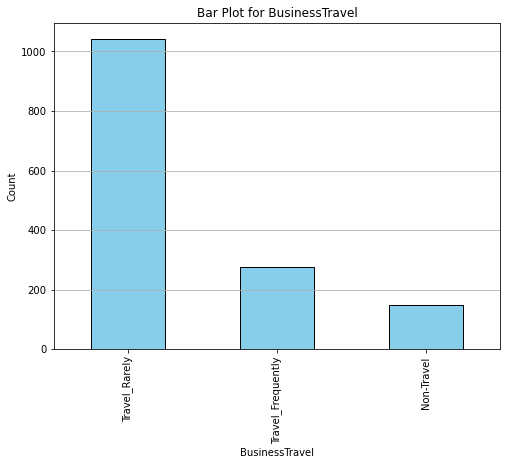

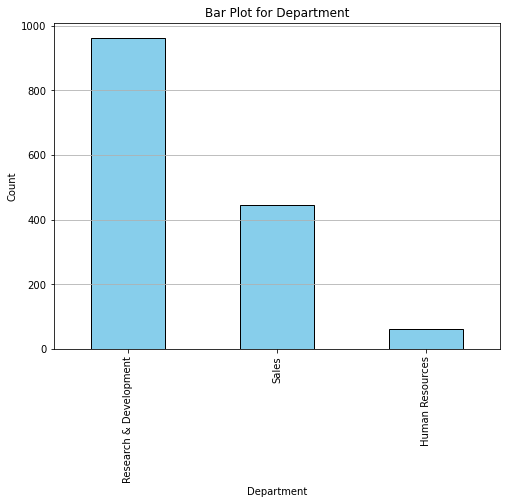

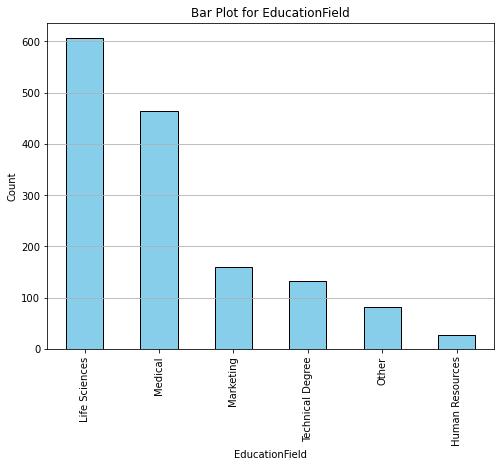

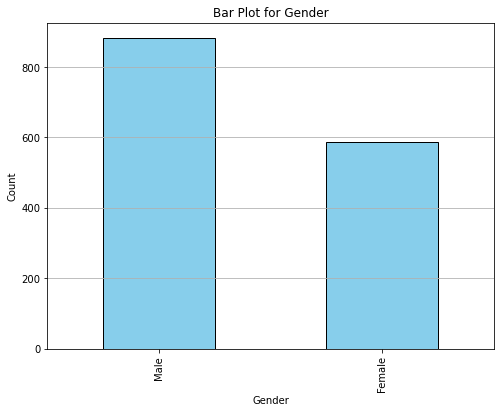

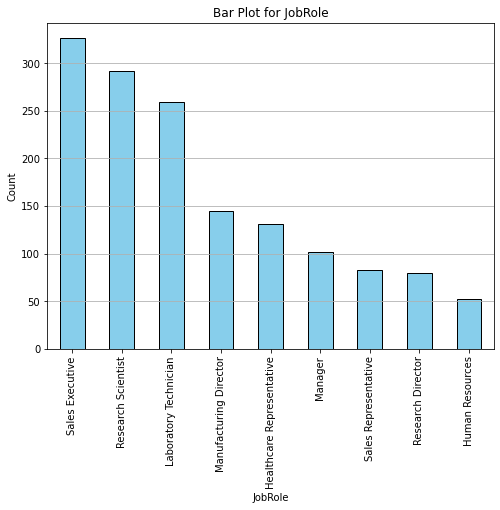

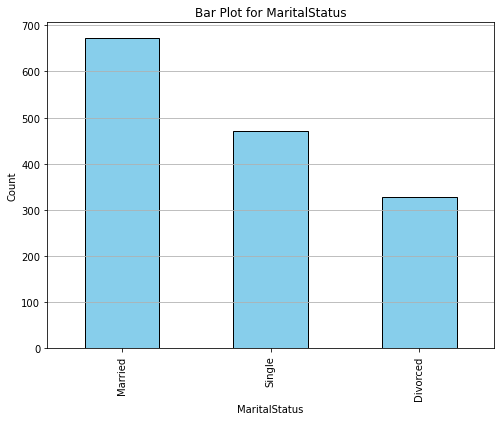

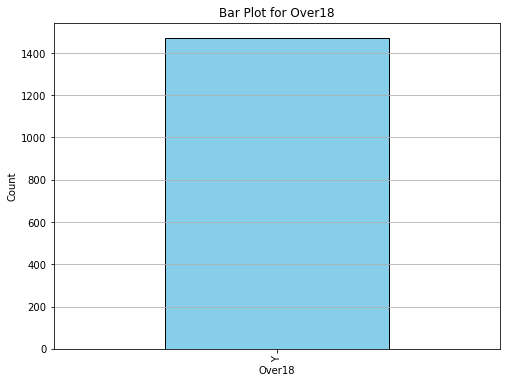

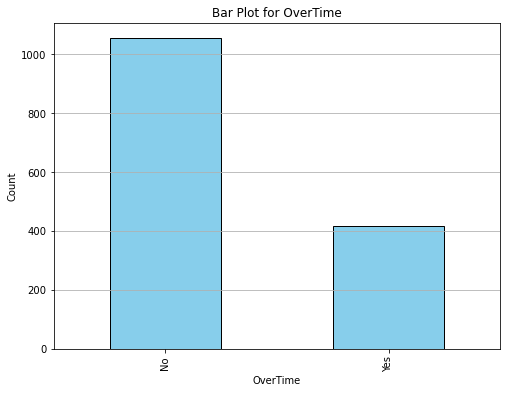

In [83]:
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

for column in non_numeric_columns:
    plt.figure(figsize=(8, 6))
    df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='k')
    plt.title(f'Bar Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.show()

I can drop the over 18 column as well. I can see that I have class imbalance in my target variable. I will look at it closer later.

In [84]:
#dropping over 18
df = df.drop(["Over18"], axis=1)

## Step 2: One hot encoding
I'm transforming my categorical variables to binary variables so that I can feed them into my model.

In [88]:
# Step 1: Split the DataFrame into target (y) and features (X)
y = df["Attrition"]  # Assuming "Attrition" is your target variable
X = df.drop("Attrition", axis=1)  # Drop the target variable to get the features

# Step 2: One-Hot Encode Categorical Variables
X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

# Step 3: Drop the original numerical columns
X_encoded = X_encoded.drop(X.select_dtypes(exclude=['object']).columns, axis=1)

# Step 4: Concatenate X_encoded with the original numerical columns
X_encoded = pd.concat([X_encoded, X.select_dtypes(exclude=['object'])], axis=1)

In [89]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   BusinessTravel_Non-Travel          1470 non-null   uint8
 1   BusinessTravel_Travel_Frequently   1470 non-null   uint8
 2   BusinessTravel_Travel_Rarely       1470 non-null   uint8
 3   Department_Human Resources         1470 non-null   uint8
 4   Department_Research & Development  1470 non-null   uint8
 5   Department_Sales                   1470 non-null   uint8
 6   EducationField_Human Resources     1470 non-null   uint8
 7   EducationField_Life Sciences       1470 non-null   uint8
 8   EducationField_Marketing           1470 non-null   uint8
 9   EducationField_Medical             1470 non-null   uint8
 10  EducationField_Other               1470 non-null   uint8
 11  EducationField_Technical Degree    1470 non-null   uint8
 12  Gender_Female       

## Step 3: Check for class imbalance

In [90]:
# Run this cell without changes 

print("Raw Counts") 

print(y.value_counts()) 

print() 

print("Percentages") 

print(y.value_counts(normalize=True)) 

Raw Counts
No     1233
Yes     237
Name: Attrition, dtype: int64

Percentages
No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64


My dataset has a strong class imbalance. Only 16% of the employees are leaving. I will have to address this by over oder undersampling after splitting the data in training and test data.

## Step 4: Bivariate analysis
Next, I'm exploring the relationship between my target variable and other features.
I'm starting with the numerical features by showing scatter plots. 

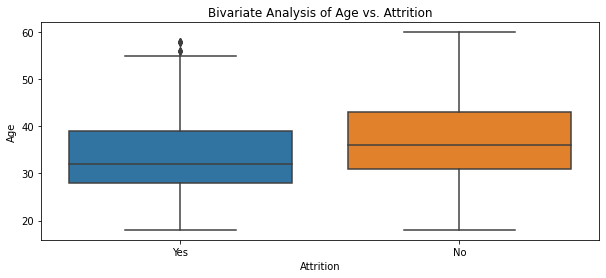

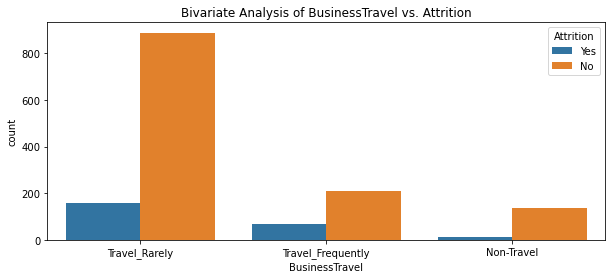

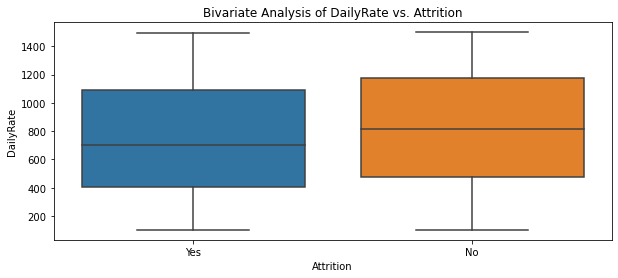

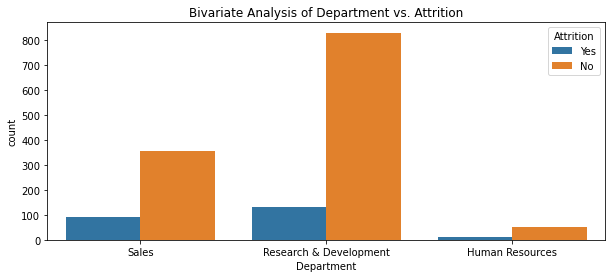

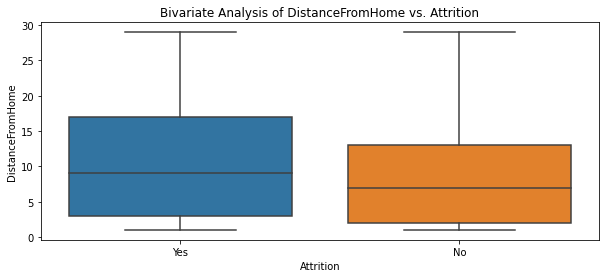

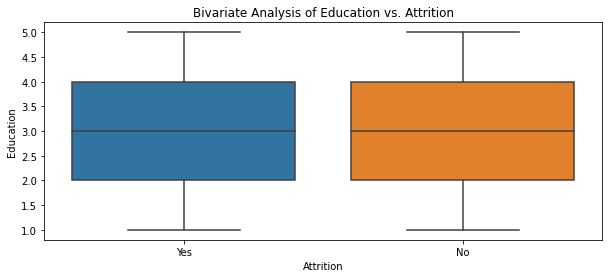

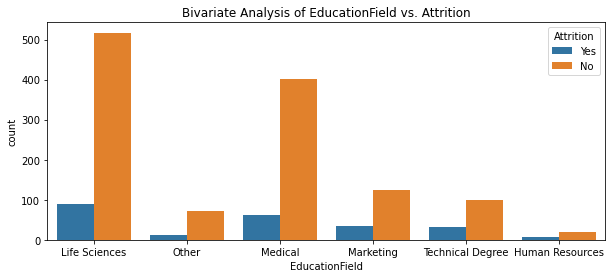

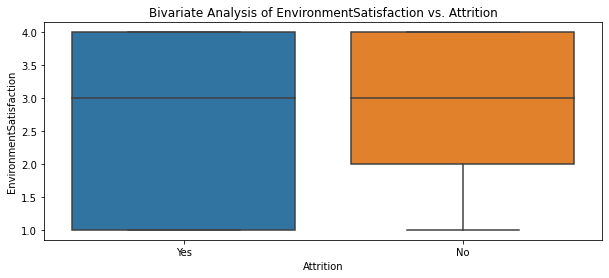

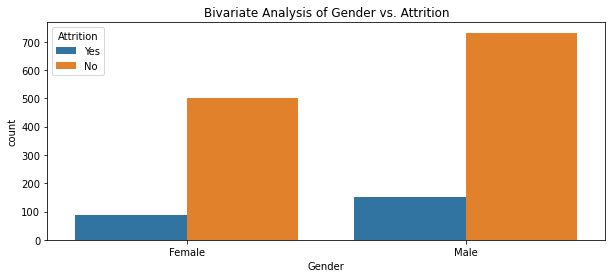

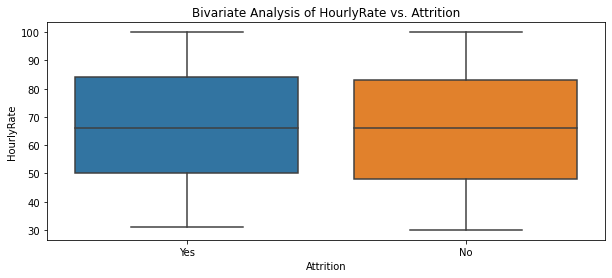

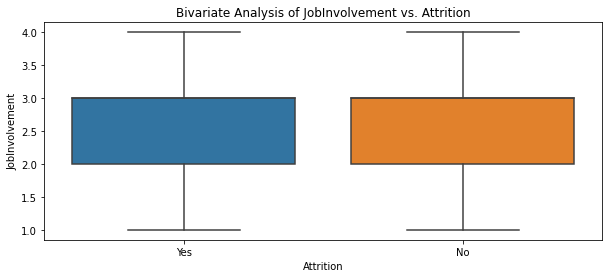

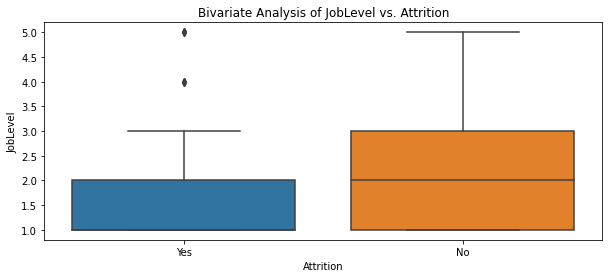

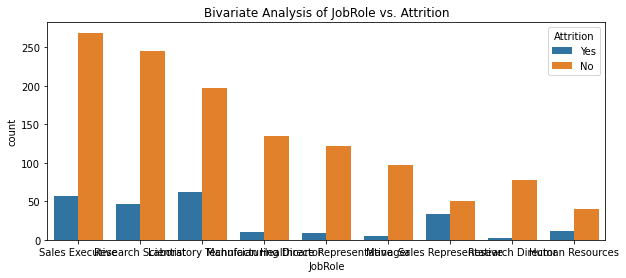

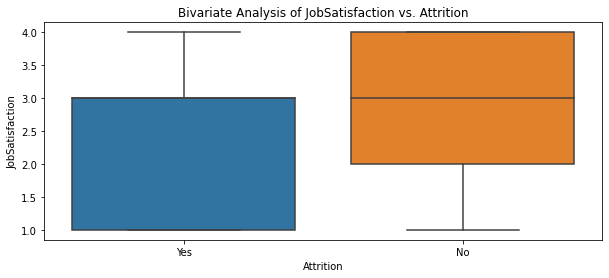

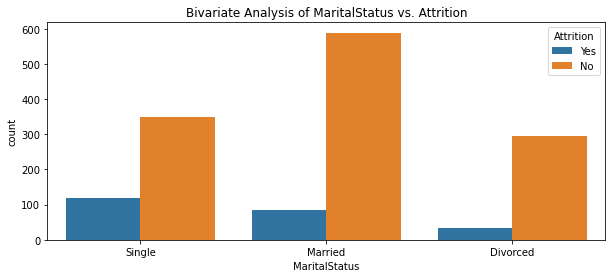

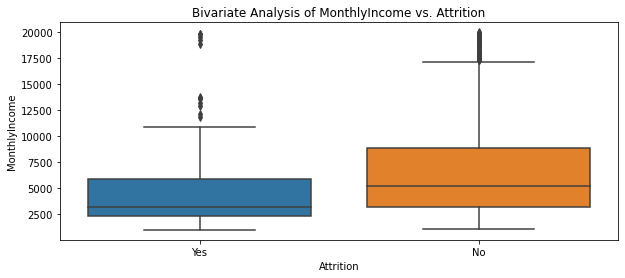

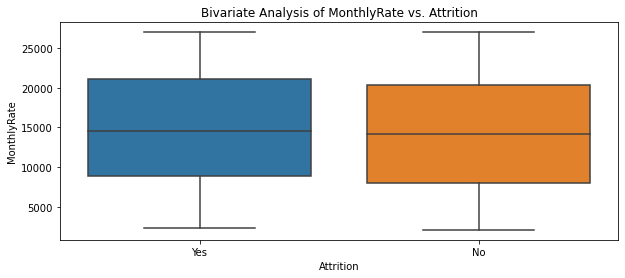

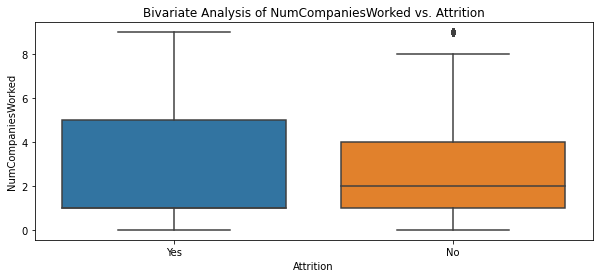

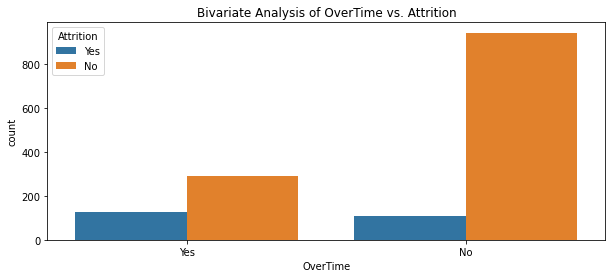

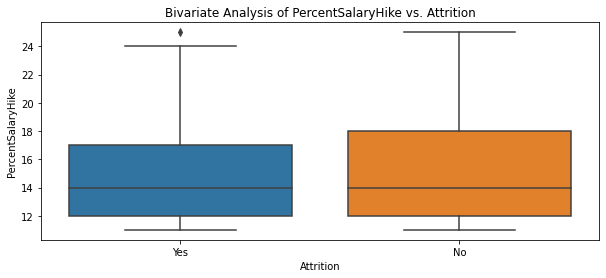

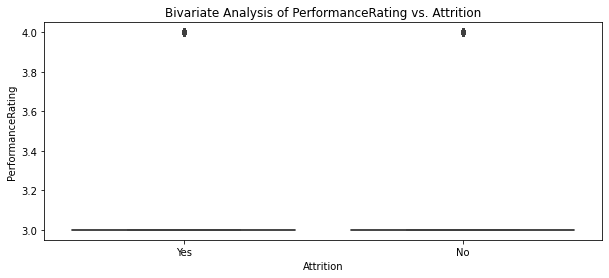

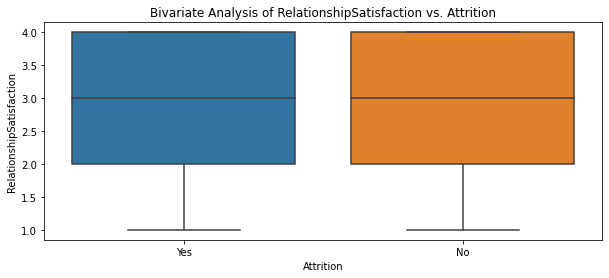

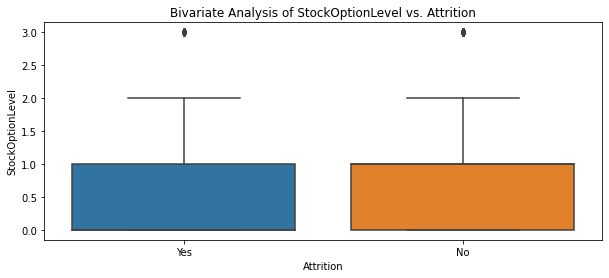

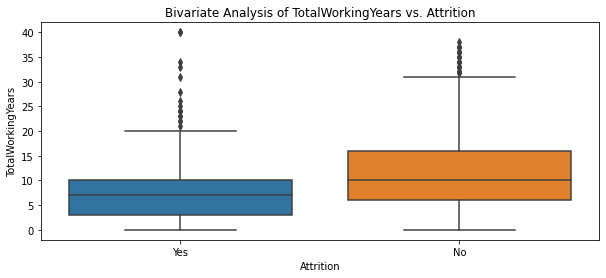

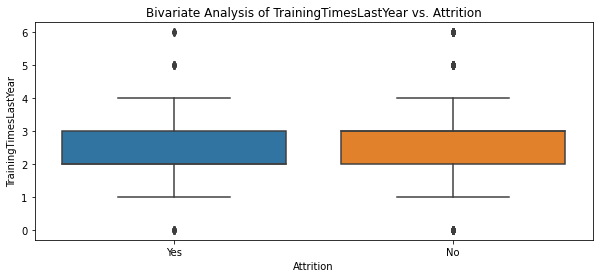

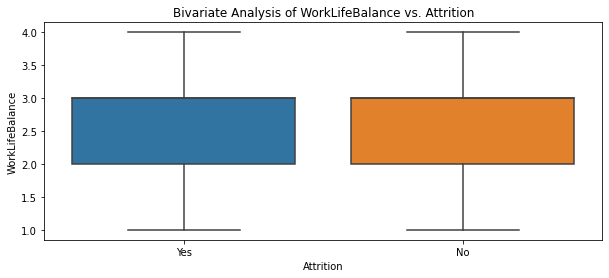

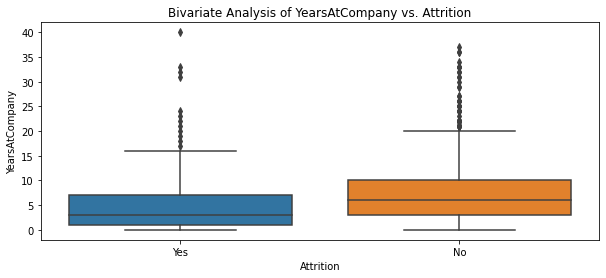

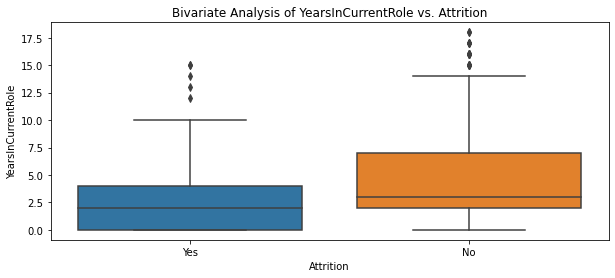

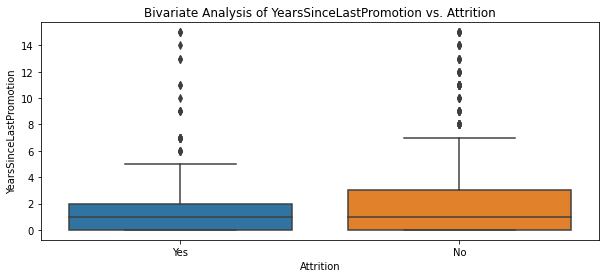

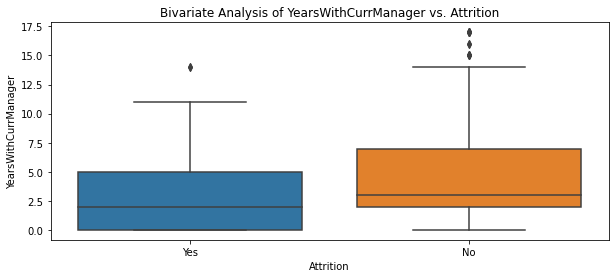

In [91]:
# Define a list of all features (exclude 'Attrition' if it's your target variable)
all_features = df.columns.tolist()
all_features.remove('Attrition')

# Create subplots for visualizing bivariate relationships for all features
for feature in all_features:
    if df[feature].dtype == 'object':
        # For categorical features, use count plots
        plt.figure(figsize=(10, 4))
        sns.countplot(x=feature, hue='Attrition', data=df)
        plt.title(f"Bivariate Analysis of {feature} vs. Attrition")
    else:
        # For numerical features, use box plots
        plt.figure(figsize=(10, 4))
        sns.boxplot(x='Attrition', y=feature, data=df)
        plt.title(f"Bivariate Analysis of {feature} vs. Attrition")
    plt.show()

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler  # You need to install the imbalanced-learn library

# Assuming 'X_encoded' is your feature matrix and 'y' is your target variable
# X_encoded and y should be preprocessed and ready for modeling

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Address class imbalance with random oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize a Random Forest classifier (you can choose another classifier if preferred)
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the resampled training data
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model performance metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

          No       0.89      0.97      0.93       255
         Yes       0.47      0.18      0.26        39

    accuracy                           0.86       294
   macro avg       0.68      0.57      0.59       294
weighted avg       0.83      0.86      0.84       294



In [102]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'X_encoded' is your feature matrix and 'y' is your target variable
# X_encoded and y should be preprocessed and ready for modeling

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize a Random Forest classifier (you can choose another classifier if preferred)
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the resampled training data
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model performance metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

          No       0.89      0.98      0.93       255
         Yes       0.64      0.23      0.34        39

    accuracy                           0.88       294
   macro avg       0.77      0.61      0.64       294
weighted avg       0.86      0.88      0.86       294



In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize a Random Forest classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make probability predictions on the test set
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of class 'Yes'

# Adjust the threshold to prioritize recall
custom_threshold = 0.3  # You can adjust this threshold as needed
y_pred = (y_prob >= custom_threshold).astype(int)

# Evaluate the model with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model performance metrics
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


TypeError: '<' not supported between instances of 'int' and 'str'

In [106]:
#SMOTE
from imblearn.over_sampling import SMOTE
oversampler=SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_resample(X_train,y_train)

In [109]:
rfc = RandomForestClassifier()
rfc = rfc.fit(smote_train , smote_target)
y_pred = rfc.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.90      0.97      0.94       255
         Yes       0.63      0.31      0.41        39

    accuracy                           0.88       294
   macro avg       0.77      0.64      0.67       294
weighted avg       0.87      0.88      0.87       294

